In this notebook, we compute invariant sets for the planar system with univariate input of Example ?.? of [???].
We need to select an semidefinite programming solver to find the invariant set. A complete list of available solvers is [available here](https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1).

In [1]:
using MosekTools
using JuMP
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET => 1))

We first define the safe sets and input sets for our system using [Polyhedra](https://github.com/JuliaPolyhedra/Polyhedra.jl).

In [2]:
using Polyhedra
G = [-0.7238   -0.5117
      0.2558   -0.8091
     -0.0528    0.7725
     -0.1060   -0.7190
     -0.1252    0.1868
      0.7232   -0.9371
      0.4235    0.6708]
F = [0.2990;
     0.0983;
     0.0276;
     0.1202;
     0.0348;
     0.0921;
     0.0240]
safe_set = polyhedron(hrep(G, F), DefaultLibrary{Float64}(solver))
# The difference between example `Planar_System_bounded_univariate_control.ipynb` is that here
# the `safe_set` have the `chebyshevcenter` at the origin and the system is linear.
# For the other example, the system becomes affine if we recenter it.
cheby_center, cheby_radius = chebyshevcenter(safe_set, solver)
safe_set = Polyhedra.translate(safe_set, -cheby_center)
input_set = polyhedron(convexhull([-2], [2]))

Polyhedron Interval{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1},StaticArrays.Size{(1,)}}:
2-element iterator of HalfSpace{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1}}:
 HalfSpace([1], 2)
 HalfSpace([-1], 2):
2-element iterator of StaticArrays.SArray{Tuple{1},Int64,1,1}:
 [2]
 [-2]

We new define the dynamic of our system and create it using [MathematicalSystems](https://github.com/JuliaReach/MathematicalSystems.jl/).

In [3]:
using MathematicalSystems
A = [1 0.1
     0 1]
B = reshape([0, 0.05], 2, 1)
system = ConstrainedLinearControlDiscreteSystem(A, B, safe_set, input_set)

ConstrainedLinearControlDiscreteSystem{Float64,Array{Float64,2},Array{Float64,2},DefaultPolyhedron{Float64,MixedMatHRep{Float64,Array{Float64,2}},MixedMatVRep{Float64,Array{Float64,2}}},Interval{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1},StaticArrays.Size{(1,)}}}([1.0 0.1; 0.0 1.0], [0.0; 0.05], HalfSpace([-0.7238, -0.5117], 0.19107440756274646) ∩ HalfSpace([0.2558, -0.8091], 0.07589831719915427) ∩ HalfSpace([-0.0528, 0.7725], 0.06925536240908901) ∩ HalfSpace([-0.106, -0.719], 0.06500410875389777) ∩ HalfSpace([-0.1252, 0.1868], 0.03296929672008322) ∩ HalfSpace([0.7232, -0.9371], 0.11135472350004738) ∩ HalfSpace([0.4235, 0.6708], 0.10986251843706862), HalfSpace([1], 2) ∩ HalfSpace([-1], 2) : convexhull([2], [-2]))

We now use SwitchOnSafety to compute the invariant set. We start with symmetric ellipsoid centered at the origin.

In [4]:
using SwitchOnSafety
sym_variable = Ellipsoid(symmetric = true)
max_vol_sym_ell = invariant_set(system, solver, sym_variable)

MOI.get(model, MOI.SolveTime()) = 0.0036399364471435547
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.0586697498001786


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.010040742772963645 -0.0003778487644907591; -0.0003778487644907591 0.007557013101736704]))

This computes the maximal *volume* ellipsoid.
We can instead maximize the integral of the quadratic form defining the ellipsoid over the hypercube.
This corresponds to maximizing the sum of squares of its semi-axes instead or equivalently the trace of the positive definite matrix defining the quadratic form.

In [5]:
max_tr_sym_ell = invariant_set(system, solver, sym_variable, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0011310577392578125
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 2.681124554607967


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.019186838008019128 -0.00012499393315962943; -0.00012499393315962943 0.0025000045402244512]))

We can see the result below.

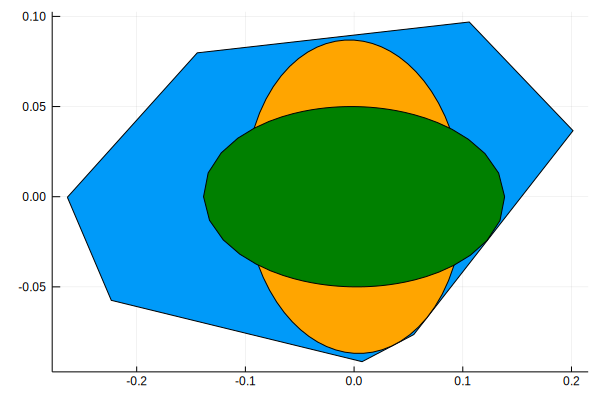

In [6]:
using Plots
plot(safe_set)
plot!(max_vol_sym_ell, color=:orange)
plot!(max_tr_sym_ell, color=:green)

We can see that forcing the center of the ellipsoid to coincide with the Chebyshev center of the safe set is quite conservative.
We can ask instead to search for any ellipsoid with the origin in its interior.
As the system is reformulated into an algebraic system with safe set `safe_set * input_set`, the Chebyshev center is `(0, 0, 0)` (not that `Polyhedra.chebyshevcenter(safe * input)` is currently incorrect because of https://github.com/JuliaPolyhedra/Polyhedra.jl/issues/125).
To avoid having to solve Bilinear Matrix Inequalities, we set the S-procedure scaling to `1.0`.

In [7]:
using SwitchOnSafety
variable = Ellipsoid(point = SetProg.InteriorPoint(zeros(3)))
max_vol_ell = invariant_set(system, solver, variable, λ = 1.0)

MOI.get(model, MOI.SolveTime()) = 0.0045719146728515625
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.06907146599476785


SetProg.Sets.Translation{SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}},Float64,Array{Float64,1}}(SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.02647468893806818 -0.0003306085054359482; -0.0003306085054359482 0.006612820744045794])), [-0.04207212928034078, 2.427812133671514e-19])

Instead of maximizing the volume, we can maximize the L1 norm as above.

In [8]:
using SwitchOnSafety
max_tr_ell = invariant_set(system, solver, variable, λ = 1.0, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0022389888763427734
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 2.6812008476199205


SetProg.Sets.Translation{SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}},Float64,Array{Float64,1}}(SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.019417556606259004 -0.00012499247498027049; -0.00012499247498027049 0.0025000055324086437])), [-0.0007474077518349916, -1.242405690276443e-16])

We can see that we get a larger ellipsoids for the volume maximization but not for the L1 norm as maximizing the L1 integral over the hypercube centered at the origin is not a very good heuristic. We should instaed maximize the L1 integral over the safe set but this is not implemented yet in [SetProg](https://github.com/blegat/SetProg.jl).

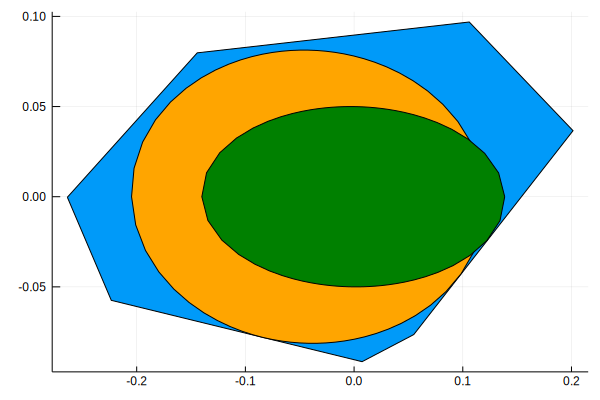

In [9]:
using Plots
plot(safe_set)
plot!(max_vol_ell, color=:orange)
plot!(max_tr_ell, color=:green)